## Import the Required Libraries

In [49]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Input
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
from keras.callbacks import EarlyStopping
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from textblob import TextBlob
import multiprocessing as mp
from sklearn.svm import SVC
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk
import time
import re

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load the Dataset

In [2]:
df = pd.read_csv('data/IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


The IMDB dataset has been loaded in the notebook. The following are the two columns of the dataset:
<ul>
    <li>
        review - This column has the movie review.
    </li>
    <li>
        sentiment - This column contains the sentiment related to the moview review.
    </li>
</ul>

## Exploratory Data Analysis

In this section, I will be performing an analysis and summarize the trends and characterstics of the dataset.

### Missing Value Check

In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: >

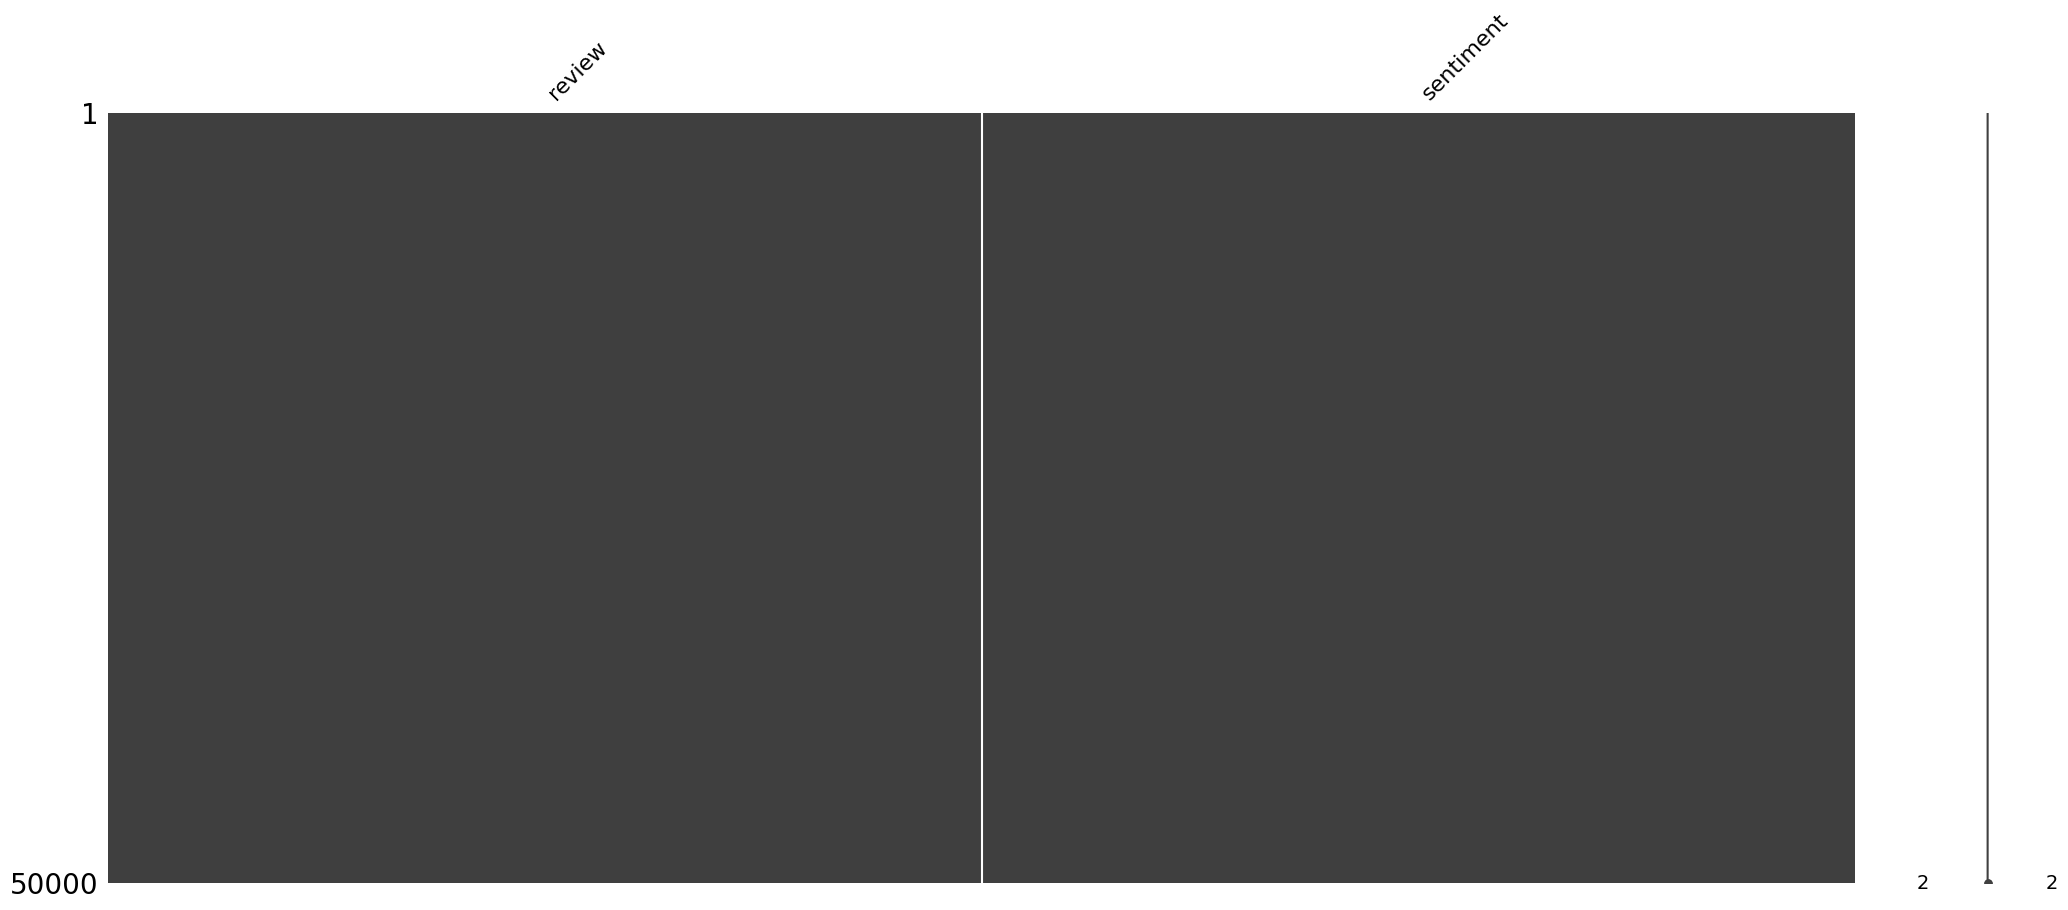

In [4]:
msno.matrix(df)

Based on the above visual and code, we can conclude that there are no mising values in the dataset.

### Check for Duplicate Records

In [5]:
df.duplicated().sum()

418

There are 418 duplicate records in total. For the purpose of my analysis, I will be exculding those records from the dataset.

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

Now, the dataset is free of duplicates.

### Check for number of classes and class distribution in dataset

In [8]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

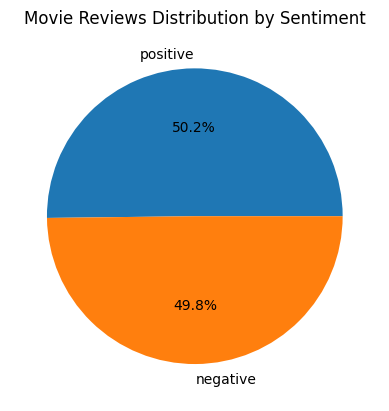

In [9]:
count_sen = df['sentiment'].value_counts(normalize=True)*100
plt.pie(count_sen, labels=count_sen.index, autopct='%1.1f%%')
plt.title('Movie Reviews Distribution by Sentiment')
plt.show()

It is observed that there are 2 classes (positive and negative) in the dataset. Also, the number of positive reviews are slightly higher than the negative reviews. There would not be significant class imbalance as the difference between the classes is quite less.

### Dataset Plots

This section includes the basic statistical analysis of data through various histogram plots.

Text(0.5, 1.0, 'Number of Characters per Positive Review')

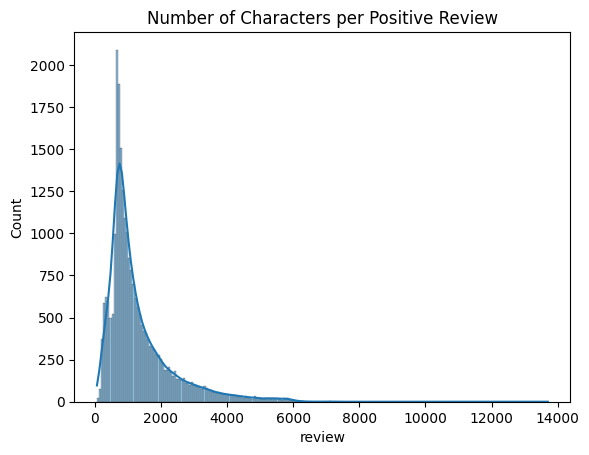

In [10]:
sns.histplot(df[df['sentiment'] == 'positive']['review'].str.len(), kde=True)
plt.title('Number of Characters per Positive Review')

Text(0.5, 1.0, 'Number of Characters per Negative Review')

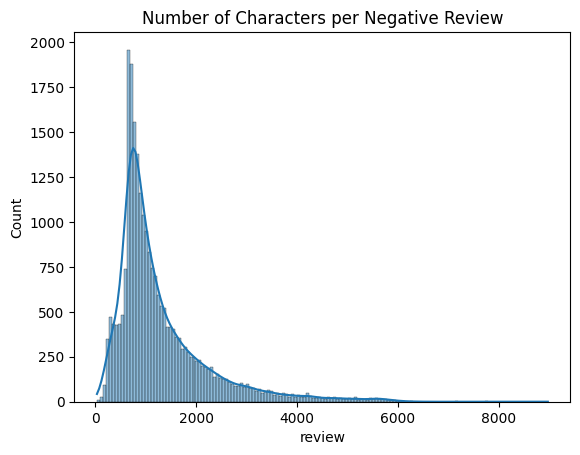

In [11]:
sns.histplot(df[df['sentiment'] == 'negative']['review'].str.len(), kde=True)
plt.title('Number of Characters per Negative Review')

Text(0.5, 1.0, 'Number of Words per Positive Review')

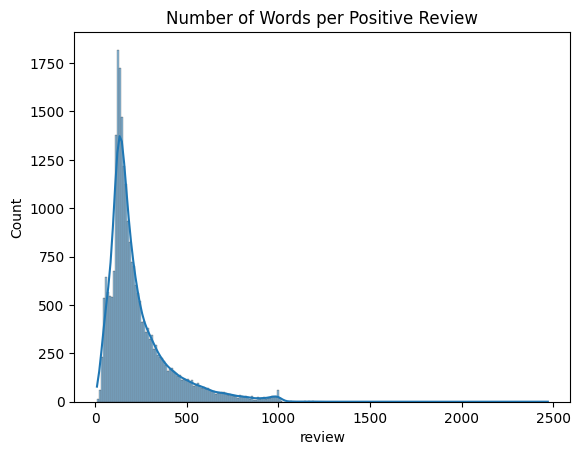

In [12]:
sns.histplot(df[df['sentiment'] == 'positive']['review'].str.split().str.len(), kde=True)
plt.title('Number of Words per Positive Review')

Text(0.5, 1.0, 'Number of Words per Negative Review')

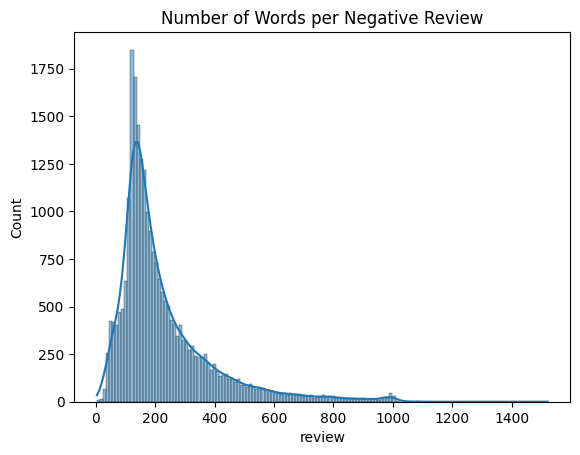

In [13]:
sns.histplot(df[df['sentiment'] == 'negative']['review'].str.split().str.len(), kde=True)
plt.title('Number of Words per Negative Review')

It is observed that the sitribution of number of words and characters is similar for both positive and negative reviews. Besides, the data is skewed towards the right.

## Data Preprocessing

This section comprises of the data preprocessing stages to clean the data before modelling phase.

### Lowercasing the text

In [14]:
df['review'] = df['review'].str.lower()

We have now lowercased all the characters in the dataset for standardizing the text across the dataset.

Upon observing the data, some of the reviews had urls in them. I believe they do not form an integral part of our nlp task. So, I will be excluding those.

### Removing HTML tags from text

In [15]:
html_reg = re.compile(r'<[^>]+/?>')

df['review'] = df['review'].str.replace(html_reg, '', regex=True)

### Removing URLs from text

In [16]:
url_pat = r'http[s]?://\S+|www\.\S+'
df['review'] = df['review'].str.replace(url_pat, '', regex=True)

Upon observing the data, I observed some HTML tags. I believe they do not form an integral part of our nlp task. So, I will be excluding those.

### Removing Emoticons from text

In [17]:
pat_emo = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [18]:
df['review'] = df['review'].str.replace(pat_emo, '', regex=True)

As the data contains movie reviews, it definitely must have emojis. So, I have removed them.

### Remove Punctuations from text

In [19]:
table_tran = str.maketrans('', '', string.punctuation)
df['review'] = df['review'].str.translate(table_tran)

Punctuations do not carry a significant meaning and might introduce noise to the nlp task. So, I have removed them.

### Expanding slang words in text

In [20]:
# referenced from github repo: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [21]:
def rem_slang_word(text):
    new_text = []
    for word in text.split():
        if word.upper() in slang_words:
            new_text.append(slang_words[word.upper()].lower())
        else:
            new_text.append(word)

    return ' '.join(new_text)

df['review'] = df['review'].apply(rem_slang_word)

Here, I expanded the commonly used slangs and abbreviations used during nlp tasks.

### Stopword Removal

In [22]:
stop_words = stopwords.words('english')
def rem_stop_word(text):
    new_text = []
    for word in text.split():
        if word in stop_words:
            new_text.append('')
        else:
            new_text.append(word)
    return ' '.join(new_text)

df['review'] = df['review'].apply(rem_stop_word)

In [23]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz e...,positive
1,wonderful little production filming techniqu...,positive
2,thought wonderful way spend tears eyes ...,positive
3,basically theres family little boy jake thi...,negative
4,petter matteis love tears eyes money vi...,positive


### Lemmatization

In [24]:
lemmatizer = WordNetLemmatizer()

def get_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    new_text = []
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    for token, pos in pos_tags:
        lemmatized_word = lemmatizer.lemmatize(token, get_pos(pos))
        new_text.append(lemmatized_word)
    
    return ' '.join(new_text)



df['review'] = df['review'].apply(lemmatize_text)

In [25]:
df.head()

,review,sentiment
0,one reviewer mention watch 1 oz episode youll ...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend tear eye hot summer ...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love tear eye money visually st...,positive


### Label Encoding the Output Label

In [26]:
enc = LabelEncoder()
df['sentiment'] = enc.fit_transform(df['sentiment'])

In [27]:
df.head()

,review,sentiment
0,one reviewer mention watch 1 oz episode youll ...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend tear eye hot summer ...,1
3,basically there family little boy jake think t...,0
4,petter matteis love tear eye money visually st...,1


### Splitting the train and test sets

In [29]:
x= df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)

### Vectorizing reviews with TF-IDF Vectorizer

In [30]:
tfidf_vec = TfidfVectorizer()
X_train_tf_idf = tfidf_vec.fit_transform(X_train)
X_test_tf_idf = tfidf_vec.transform(X_test)

### Vectorizing reviews with Bag of Words

In [31]:
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train)
X_test_bow = count_vec.transform(X_test)

## Model Functions for Machine Learning

In [32]:
acc_dict = dict()
train_time_list, test_time_list = [list() for _ in range(2)]

def model_util(model, X_train, X_test, y_train, y_test):
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()

    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    end_pred_time = time.time()

    train_time = end_train_time - start_train_time
    pred_time = end_pred_time - start_pred_time

    train_time_list.append(train_time)
    test_time_list.append(pred_time)
    
    print(classification_report(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

def ml_model(model_param, X_train, X_test, y_train, y_test):
    if model_param == 'logistic':
        print('Logistic Regression')
        model = LogisticRegression()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['Logistic Regression'] = acc

    elif model_param == 'SGD':
        print('SGD')
        model = SGDClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['SGD'] = acc       

    elif model_param == 'RF':
        print('Random Forest')
        model = RandomForestClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['Random Forest'] = acc

    elif model_param == 'XGB':
        print('XgBoost')
        model = XGBClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['XgBoost'] = acc  

    elif model_param == 'NB':
        print('Multinomial Naive Bayes')
        model = MultinomialNB()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['Multinomial Naive Bayes'] = acc

    elif model_param == 'KNN':
        print('KNN')
        model = KNeighborsClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['KNN'] = acc

    elif model_param == 'SVM':
        print('SVM')
        model = SVC()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['SVM'] = acc   

    elif model_param == 'DT':
        print('Decision Tree')
        model = DecisionTreeClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['Decision Tree'] = acc   

    elif model_param == 'ADA':
        print('AdaBoost')
        model = AdaBoostClassifier()
        acc = model_util(model, X_train, X_test, y_train, y_test)
        print('Accuracy Score: ', acc)
        acc_dict['AdaBoost'] = acc   

In [34]:
ml_model('logistic', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      6168
           1       0.88      0.90      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Accuracy Score:  0.8858502742820265


In [33]:
ml_model('SGD', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

SGD
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6168
           1       0.87      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Accuracy Score:  0.8851242336237496


In [34]:
ml_model('RF', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Random Forest
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      6168
           1       0.85      0.84      0.85      6228

    accuracy                           0.85     12396
   macro avg       0.85      0.85      0.85     12396
weighted avg       0.85      0.85      0.85     12396

Accuracy Score:  0.8453533397870281


In [35]:
ml_model('XGB', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

XgBoost
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      6168
           1       0.83      0.87      0.85      6228

    accuracy                           0.85     12396
   macro avg       0.85      0.85      0.85     12396
weighted avg       0.85      0.85      0.85     12396

Accuracy Score:  0.8478541464988706


In [36]:
ml_model('NB', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6168
           1       0.87      0.85      0.86      6228

    accuracy                           0.86     12396
   macro avg       0.86      0.86      0.86     12396
weighted avg       0.86      0.86      0.86     12396

Accuracy Score:  0.8593901258470474


In [37]:
ml_model('KNN', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

KNN
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      6168
           1       0.74      0.84      0.79      6228

    accuracy                           0.77     12396
   macro avg       0.77      0.77      0.77     12396
weighted avg       0.77      0.77      0.77     12396

Accuracy Score:  0.7698451113262342


In [38]:
ml_model('SVM', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

SVM
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6168
           1       0.88      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Accuracy Score:  0.8914972571797354


In [39]:
ml_model('DT', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Decision Tree
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6168
           1       0.71      0.71      0.71      6228

    accuracy                           0.71     12396
   macro avg       0.71      0.71      0.71     12396
weighted avg       0.71      0.71      0.71     12396

Accuracy Score:  0.7057115198451114


In [43]:
ml_model('ADA', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

AdaBoost


C:\Users\anshu\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.76      0.79      6168
           1       0.78      0.83      0.80      6228

    accuracy                           0.80     12396
   macro avg       0.80      0.79      0.79     12396
weighted avg       0.80      0.80      0.79     12396

Accuracy Score:  0.7950951919974185


In [47]:
df = pd.DataFrame(list(acc_dict.items()), columns=['Model', 'Accuracy'])
df['Train Time'] = train_time_list
df['Test Time'] = test_time_list

df.head(9)

,Model,Accuracy,Train Time,Test Time
0,Logistic Regression,0.885850,28.437768,0.005243
1,SGD,0.885124,0.372072,0.000000
2,Random Forest,0.845353,296.082775,1.746324
3,XgBoost,0.847854,107.095726,0.408881
4,Multinomial Naive Bayes,0.859390,0.075330,0.015760
5,KNN,0.769845,0.046764,45.764571
6,SVM,0.891497,4056.629081,550.908957
7,Decision Tree,0.705712,141.810120,0.015676
8,AdaBoost,0.795095,73.193243,0.952352


Here SVM has the highest accuracy, however, it has significant train and test times. It is observed that Logistic Regression and SGD have similar accuracy values. However SGD has a lower train and test time and would be considered optimal (with tfidf vectorization).

Now ML models are analyzed with Bag of Words

In [43]:
ml_model('logistic', X_train_bow, X_test_bow, y_train, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      6168
           1       0.87      0.89      0.88      6228

    accuracy                           0.88     12396
   macro avg       0.88      0.88      0.88     12396
weighted avg       0.88      0.88      0.88     12396

Accuracy Score:  0.8791545659890287


In [44]:
ml_model('SGD', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

SGD
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      6168
           1       0.87      0.90      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Accuracy Score:  0.8862536302032914


In [45]:
ml_model('RF', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Random Forest
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6168
           1       0.84      0.83      0.84      6228

    accuracy                           0.84     12396
   macro avg       0.84      0.84      0.84     12396
weighted avg       0.84      0.84      0.84     12396

Accuracy Score:  0.8397063568893192


In [46]:
ml_model('XGB', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

XgBoost
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      6168
           1       0.83      0.87      0.85      6228

    accuracy                           0.85     12396
   macro avg       0.85      0.85      0.85     12396
weighted avg       0.85      0.85      0.85     12396

Accuracy Score:  0.8478541464988706


In [47]:
ml_model('NB', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6168
           1       0.87      0.85      0.86      6228

    accuracy                           0.86     12396
   macro avg       0.86      0.86      0.86     12396
weighted avg       0.86      0.86      0.86     12396

Accuracy Score:  0.8593901258470474


In [48]:
ml_model('KNN', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

KNN
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      6168
           1       0.74      0.84      0.79      6228

    accuracy                           0.77     12396
   macro avg       0.77      0.77      0.77     12396
weighted avg       0.77      0.77      0.77     12396

Accuracy Score:  0.7698451113262342


In [49]:
ml_model('SVM', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

SVM
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6168
           1       0.88      0.91      0.89      6228

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

Accuracy Score:  0.8914972571797354


In [50]:
ml_model('DT', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

Decision Tree
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6168
           1       0.71      0.70      0.70      6228

    accuracy                           0.70     12396
   macro avg       0.70      0.70      0.70     12396
weighted avg       0.70      0.70      0.70     12396

Accuracy Score:  0.7026460148434979


In [51]:
ml_model('ADA', X_train_tf_idf, X_test_tf_idf, y_train, y_test)

AdaBoost
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      6168
           1       0.78      0.83      0.80      6228

    accuracy                           0.80     12396
   macro avg       0.80      0.79      0.79     12396
weighted avg       0.80      0.80      0.79     12396

Accuracy Score:  0.7950951919974185


In [52]:
df = pd.DataFrame(list(acc_dict.items()), columns=['Model', 'Accuracy'])
df['Train Time'] = train_time_list
df['Test Time'] = test_time_list

df.head(9)

,Model,Accuracy,Train Time,Test Time
0,Logistic Regression,0.879155,48.664650,0.011509
1,SGD,0.886254,0.409866,0.000000
2,Random Forest,0.839706,416.144206,1.961624
3,XgBoost,0.847854,115.833893,0.336175
4,Multinomial Naive Bayes,0.859390,0.077663,0.016044
5,KNN,0.769845,0.028700,56.529337
6,SVM,0.891497,5646.343555,555.854692
7,Decision Tree,0.702646,144.223592,0.015750
8,AdaBoost,0.795095,70.937681,0.940739


Here SVM has the highest accuracy, however, it has significant train and test times. It is observed that SGD have high accuracy values among both methods (with tfidf vectorization and bag of words) and therefore would be an optimal machine learning model

## Deep Learning Models

### Tokenization

In [40]:
tokn = Tokenizer(num_words = 5000)
tokn.fit_on_texts(df['review'])
se = tokn.texts_to_sequences(df['review'])

### Setting Threshold Review length at 70%

In [41]:
df['review length'] = df['tokens'].apply(len)
L_val = int(np.percentile(df['review length'], 70))

### Padding the reviews based on the threshold value

In [46]:
pd_list = pad_sequences(se, padding='pre', truncating='post', maxlen = L_val)

labels = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(pd_list, labels, test_size=0.25, random_state=42)

### MLP Model

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

multi_md = Sequential()
multi_md.add(Embedding(input_dim=5000, output_dim=256, input_length=L_val))
multi_md.add(Flatten())
multi_md.add(Dense(128, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(64, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(64, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(1, activation='sigmoid'))

multi_md.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
multi_md.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])
training_time = time.time() - start_time

start_time = time.time()

_, train_acc = multi_md.evaluate(X_train, y_train)
_, test_acc = multi_md.evaluate(X_test, y_test)
testing_time = time.time() - start_time

print(f"Training Time: {training_time}")
print(f"Testing Time: {testing_time}")
print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

Epoch 1/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 128s 54ms/step - accuracy: 0.6861 - loss: 0.5546 - val_accuracy: 0.8634 - val_loss: 0.3338
Epoch 2/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 142s 53ms/step - accuracy: 0.9180 - loss: 0.2256 - val_accuracy: 0.8396 - val_loss: 0.3570
Epoch 3/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 121s 52ms/step - accuracy: 0.9727 - loss: 0.0829 - val_accuracy: 0.8442 - val_loss: 0.5614
Epoch 4/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 122s 53ms/step - accuracy: 0.9885 - loss: 0.0388 - val_accuracy: 0.8415 - val_loss: 0.7987
Epoch 5/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 123s 53ms/step - accuracy: 0.9915 - loss: 0.0278 - val_accuracy: 0.8389 - val_loss: 0.6276
Epoch 6/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 123s 53ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 0.8340 - val_loss: 1.1038
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9295 - loss: 0.2346
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8625 - loss: 0.3354
Training Time: 759.1522171497345
Testing Time: 11.

### LSTM Model

In [60]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
model_lstm.add(LSTM(32, dropout=0.2))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])
training_time = time.time() - start_time

start_time = time.time()

_, train_accuracy = model_lstm.evaluate(X_train, y_train)
_, test_accuracy = model_lstm.evaluate(X_test, y_test)
testing_time = time.time() - start_time

print(f"Training Time: {training_time}")
print(f"Testing Time: {testing_time}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Epoch 1/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.7766 - loss: 0.4563 - val_accuracy: 0.8679 - val_loss: 0.3084
Epoch 2/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.8943 - loss: 0.2692 - val_accuracy: 0.8653 - val_loss: 0.3142
Epoch 3/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.9148 - loss: 0.2270 - val_accuracy: 0.8625 - val_loss: 0.3406
Epoch 4/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 129s 56ms/step - accuracy: 0.9270 - loss: 0.1917 - val_accuracy: 0.8623 - val_loss: 0.3451
Epoch 5/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 131s 56ms/step - accuracy: 0.9354 - loss: 0.1774 - val_accuracy: 0.8520 - val_loss: 0.3940
Epoch 6/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.9476 - loss: 0.1421 - val_accuracy: 0.8577 - val_loss: 0.3997
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9082 - loss: 0.2413
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8681 - loss: 0.3098
Training Time: 560.393346786499
Testing Time: 22.29

### CNN Model

In [61]:
conv_1d_model = Sequential()
conv_1d_model.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
conv_1d_model.add(Conv1D(kernel_size=3, filters=32, activation='relu'))
conv_1d_model.add(MaxPooling1D(pool_size=2, strides=2))
conv_1d_model.add(Flatten())
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.2))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(1, activation='sigmoid'))

conv_1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
conv_1d_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])
training_time = time.time() - start_time


start_time = time.time()
_, train_accuracy = conv_1d_model.evaluate(X_train, y_train)
_, test_accuracy = conv_1d_model.evaluate(X_test, y_test)
testing_time = time.time() - start_time

print(f"Training Time: {training_time}")
print(f"Testing Time: {testing_time}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Epoch 1/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.6754 - loss: 0.5475 - val_accuracy: 0.8704 - val_loss: 0.3108
Epoch 2/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.9000 - loss: 0.2617 - val_accuracy: 0.8750 - val_loss: 0.3133
Epoch 3/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9291 - loss: 0.1949 - val_accuracy: 0.8675 - val_loss: 0.3311
Epoch 4/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.9567 - loss: 0.1275 - val_accuracy: 0.8602 - val_loss: 0.4718
Epoch 5/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9748 - loss: 0.0744 - val_accuracy: 0.8600 - val_loss: 0.5287
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9155 - loss: 0.2316
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8724 - loss: 0.3105
Training Time: 162.8201847076416
Testing Time: 4.105626583099365
Training Accuracy: 0.9116334319114685
Testing Accuracy: 0.8703613877296448


Among all the three considered deep learning models, CNN has performed better both in terms of Test Accuracy and a lower time on the test set.

## Conclusion

Among all the considered approaches, it is observed that Stochastic Gradient Descent (SGD) with Bag of Words feature extraction method is the most optimal approach both in terms of prediction accuracy (88.6% on test set) and lowering the time needed to process the test set.